<a href="https://colab.research.google.com/github/weilainicolas/Deep-Learning/blob/master/L7_Feature_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import fastai 
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [2]:
path=untar_data(URLs.PETS)
path_hr=path/'images'
path_mr=path/'s-256'
path_lr=path/'s-96'

In [0]:
il=ImageList.from_folder(path_hr)

In [4]:
il.items[0].name

'Maine_Coon_171.jpg'

In [0]:
def size_one(fn,path,size):
  dest=path/fn.name
  dest.parent.mkdir(parents=True, exist_ok=True)
  img=PIL.Image.open(fn)
  targ_size=resize_to(img,size,use_min=True)
  img=img.resize(targ_size,resample=PIL.Image.BILINEAR).convert('RGB')
  img.save(dest,quality=60)


In [0]:
len(il.items)

7390

In [6]:
sets=[(96,path_lr),(256,path_mr)]
for s,p in sets:
  if not p.exists():
    print(f"resize to {s} into {p}")
    for i in range(len(il.items)):
      size_one(il.items[i],p,s)

resize to 96 into /root/.fastai/data/oxford-iiit-pet/s-96
resize to 256 into /root/.fastai/data/oxford-iiit-pet/s-256


In [0]:
bs,size=32,128
arch=models.resnet34
src=ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs, size):
  data=(src.label_from_func(lambda x: path_hr/x.name)
      .transform(get_transforms(max_zoom=2.),size=size,tfm_y=True)
      .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
  data.c=3
  return data


In [0]:
data=get_data(bs, size)

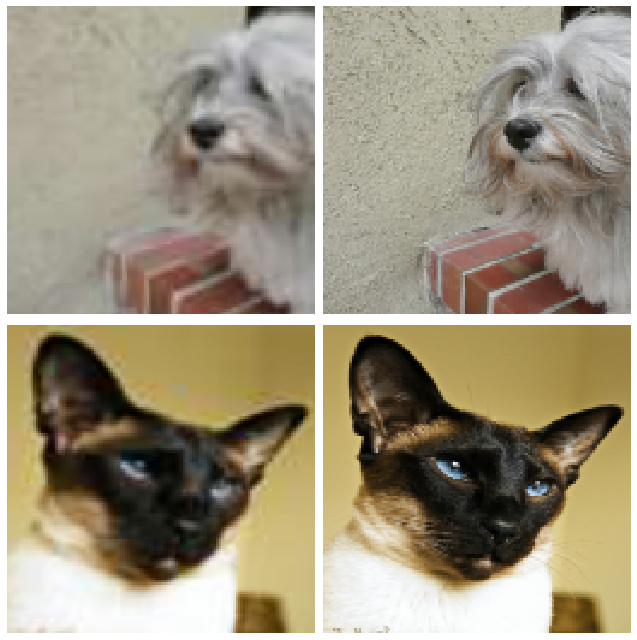

In [10]:
data.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(9,9))

In [0]:
t=data.valid_ds[0][1].data
t=torch.stack([t,t])

In [0]:
def gram_matrix(x):
  n,c,h,w=x.size()
  x=x.view(n,c,-1)
  return (x @ x.transpose(1,2))/(c*h*w)

In [28]:
print(t.view(2,3,-1).transpose(1,2).size()),
print(t.view(2,3,-1).size())

torch.Size([2, 16384, 3])
torch.Size([2, 3, 16384])


In [0]:
bass_loss=F.l1_loss

In [0]:
vgg_m=vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [90]:
blocks= [i-1 for i in range(len(vgg_m)) if isinstance(vgg_m[i],nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(nn.Module):
  def __init__(self,m_feat,layer_ids,layer_wgts):
    super().__init__()
    self.m_feat=m_feat
    self.loss_features= [self.m_feat[i] for i in layer_ids]
    self.hooks=hook_outputs(self.loss_features, detach=False)
    self.wgts=layer_wgts
    self.metric_names=['pixel',]+[f'feat_{i}' for i in range(len(layer_ids))
                        ]+ [f'gram_{i}' for i in range(len(layer_ids))]
    def make_features(self,x,clone=False):
      self.m_feat(x)
      return [(o.clone() if clone else o) for o in self.hooks.stored]
    def forward(self, input, target):
      out_feat=self.make_features(target, clone=True)
      in_feat=self.make_features(input) 
      self.feat_losses= [base_loss(input,target)]
      self.feat_losses+=[base_loss(f_in, f_out)*w for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)] 
      self.feat_losses+=[base_loss(gram_matrix(f_in),gram_matrix(f_out))*w**2*5e3 for f_in, f_out, w in zip(in_feat,out_feat,self.wgts)]
      self.metrics= dict(zip(self.metrics_names, self.feat_losses))
      return sum(self.feat_looses)
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss=FeatureLoss(vgg_m, blocks[2:5],[5,15,2])

In [0]:
wd=1e-3
learn=unet_learner(data, arch ,wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,blur=True, norm_type=NormType.Weight)

In [95]:
gc.collect()

2854

In [96]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


NotImplementedError: ignored